In [1]:
from pynq import Overlay
from pynq import allocate
import numpy as np

# Adjust path to your bitstream here
overlay = Overlay("/home/xilinx/jupyter_notebooks/design_1_wrapper.xsa")



In [2]:
help(overlay)

Help on Overlay in module pynq.overlay:

<pynq.overlay.Overlay object>
    Default documentation for overlay /home/xilinx/jupyter_notebooks/design_1_wrapper.xsa. The following
    attributes are available on this overlay:
    
    IP Blocks
    ----------
    sr_fft_0             : pynq.overlay.DefaultIP
    processing_system7_0 : pynq.overlay.DefaultIP
    
    Hierarchies
    -----------
    None
    
    Interrupts
    ----------
    None
    
    GPIO Outputs
    ------------
    None
    
    Memories
    ------------
    PSDDR                : Memory



In [12]:
fft_ip = overlay.sr_fft_0

In [13]:
import numpy as np
from pynq import MMIO
from time import sleep

# Base addresses from your info
CTRL_BASEADDR = 0x40000000   # Control registers + memories start here
CTRL_SPACE = 0x1000           # 4KB space to map whole IP (includes control + memories)

mmio = MMIO(CTRL_BASEADDR, CTRL_SPACE)


In [14]:
N = 64
freq_bin = 10
PI = np.pi

# Generate complex input data (complex64)
input_data = np.zeros(N, dtype=np.complex64)

for i in range(N):
    phase = 2 * PI * freq_bin * i / N
    input_data[i] = np.cos(phase) + 1j * np.sin(phase)


In [15]:
def bank_offset_input(bank_num: int) -> int:
    return 0x40 + bank_num * 0x40

def bank_offset_output(bank_num: int) -> int:
    return 0x240 + bank_num * 0x40


In [16]:
def write_complex_bank(mmio: MMIO, bank_num: int, data: np.ndarray):
    assert data.size == 8, "Bank data must be of length 8"
    assert data.dtype == np.complex64, "Data dtype must be complex64"
    offset = bank_offset_input(bank_num)
    # Convert complex64 array to bytes
    bytes_data = data.tobytes()
    # MMIO.data is a bytearray, write 64 bytes one-by-one
    for i in range(len(bytes_data)):
        mmio.write(offset + i, bytes_data[i])


In [17]:
def read_complex_bank(mmio: MMIO, bank_num: int) -> np.ndarray:
    offset = bank_offset_output(bank_num)
    # Read 64 bytes from MMIO memory bank
    banks_bytes = bytearray(64)
    for i in range(64):
        banks_bytes[i] = mmio.read(offset + i) & 0xFF
    # Convert to complex64 array
    return np.frombuffer(banks_bytes, dtype=np.complex64)


In [19]:
import numpy as np
from pynq import MMIO
import time

# SR FFT IP Configuration
CTRL_BASEADDR = 0x40000000  # Base address from your paste-6.txt
CTRL_SPACE = 0x1000         # 4KB address space
N = 64                      # FFT size (64 points)
NUM_BANKS = 8              # Number of input/output banks
SAMPLES_PER_BANK = 8       # Complex samples per bank

# Initialize MMIO interface
mmio = MMIO(CTRL_BASEADDR, CTRL_SPACE)
print("MMIO interface initialized successfully")


MMIO interface initialized successfully


In [20]:
# Control register offsets (from xsr_fft_hw.h)
AP_CTRL_OFFSET = 0x000
GIE_OFFSET = 0x004
IER_OFFSET = 0x008
ISR_OFFSET = 0x00c

# Input memory bank offsets
INPUT_OFFSETS = [0x040, 0x080, 0x0c0, 0x100, 0x140, 0x180, 0x1c0, 0x200]

# Output memory bank offsets  
OUTPUT_OFFSETS = [0x240, 0x280, 0x2c0, 0x300, 0x340, 0x380, 0x3c0, 0x400]

print("Hardware register offsets defined")


Hardware register offsets defined


In [21]:
def start_fft():
    """Start the FFT computation by setting ap_start bit"""
    ctrl_reg = mmio.read(AP_CTRL_OFFSET)
    mmio.write(AP_CTRL_OFFSET, ctrl_reg | 0x01)
    print("FFT started")

def is_fft_done():
    """Check if FFT computation is complete by reading ap_done bit"""
    ctrl_reg = mmio.read(AP_CTRL_OFFSET)
    return (ctrl_reg >> 1) & 0x01

def wait_for_completion(timeout_sec=2.0):
    """Wait for FFT to complete with timeout"""
    start_time = time.time()
    while not is_fft_done():
        if time.time() - start_time > timeout_sec:
            raise TimeoutError("FFT computation timed out")
        time.sleep(0.001)  # 1ms polling interval
    print("FFT computation completed")

def reset_ip():
    """Reset the IP by clearing control register"""
    mmio.write(AP_CTRL_OFFSET, 0x00)
    print("IP reset")


In [23]:
def write_complex_bank(bank_num, complex_data):
    """Write 8 complex64 samples to specified input bank"""
    if bank_num < 0 or bank_num >= NUM_BANKS:
        raise ValueError(f"Bank number must be 0-{NUM_BANKS-1}")
    
    if len(complex_data) != SAMPLES_PER_BANK:
        raise ValueError(f"Must provide exactly {SAMPLES_PER_BANK} complex samples")
    
    # Convert complex64 array to uint32 view for MMIO writing
    complex_array = np.array(complex_data, dtype=np.complex64)
    uint32_view = complex_array.view(np.uint32)  # 16 uint32 values
    
    # Write to input bank memory
    base_offset = INPUT_OFFSETS[bank_num]
    for i, value in enumerate(uint32_view):
        mmio.write(base_offset + i*4, int(value))
    
    print(f"Written {len(complex_data)} samples to input bank {bank_num}")

def read_complex_bank(bank_num):
    """Read 8 complex64 samples from specified output bank"""
    if bank_num < 0 or bank_num >= NUM_BANKS:
        raise ValueError(f"Bank number must be 0-{NUM_BANKS-1}")
    
    # Read 16 uint32 values (8 complex64 = 16 uint32)
    base_offset = OUTPUT_OFFSETS[bank_num]
    uint32_values = []
    
    for i in range(16):  # 16 uint32 words = 8 complex64 samples
        value = mmio.read(base_offset + i*4)
        uint32_values.append(value)
    
    # Convert uint32 array back to complex64
    uint32_array = np.array(uint32_values, dtype=np.uint32)
    complex_array = uint32_array.view(np.complex64)
    
    return complex_array

def write_all_input_banks(input_data):
    """Write 64 complex samples across all 8 input banks"""
    if len(input_data) != N:
        raise ValueError(f"Input data must have exactly {N} samples")
    
    # Split data into 8 banks of 8 samples each
    input_banks = np.array(input_data).reshape(NUM_BANKS, SAMPLES_PER_BANK)
    
    for bank_num in range(NUM_BANKS):
        write_complex_bank(bank_num, input_banks[bank_num])
    
    print(f"All {N} input samples written to {NUM_BANKS} banks")

def read_all_output_banks():
    """Read 64 complex samples from all 8 output banks"""
    output_data = []
    
    for bank_num in range(NUM_BANKS):
        bank_data = read_complex_bank(bank_num)
        output_data.extend(bank_data)
    
    print(f"All {len(output_data)} output samples read from {NUM_BANKS} banks")
    return np.array(output_data)


In [24]:
def generate_test_signal(freq_bin=10):
    """Generate complex exponential test signal at specified frequency bin"""
    input_signal = np.zeros(N, dtype=np.complex64)
    
    for i in range(N):
        phase = 2.0 * np.pi * freq_bin * i / N
        input_signal[i] = np.cos(phase) + 1j * np.sin(phase)
    
    print(f"Generated test signal: complex exponential at frequency bin {freq_bin}")
    return input_signal

# Generate the test input signal
freq_bin = 10
input_data = generate_test_signal(freq_bin)
print(f"Input signal shape: {input_data.shape}, dtype: {input_data.dtype}")


Generated test signal: complex exponential at frequency bin 10
Input signal shape: (64,), dtype: complex64


In [25]:
def run_fft_test():
    """Complete FFT test execution"""
    
    print("=" * 60)
    print("Starting SR FFT IP Test")
    print("=" * 60)
    
    try:
        # Step 1: Reset IP
        reset_ip()
        time.sleep(0.1)
        
        # Step 2: Write input data to all banks
        print("\n1. Writing input data to memory banks...")
        write_all_input_banks(input_data)
        
        # Step 3: Start FFT computation
        print("\n2. Starting FFT computation...")
        start_fft()
        
        # Step 4: Wait for completion
        print("\n3. Waiting for FFT completion...")
        wait_for_completion()
        
        # Step 5: Read output data from all banks
        print("\n4. Reading output data from memory banks...")
        output_data = read_all_output_banks()
        
        # Step 6: Display results
        print("\n5. FFT Results:")
        print(f"FFT output magnitudes at bins around frequency {freq_bin}:")
        
        for i in range(freq_bin - 3, freq_bin + 4):
            idx = i % N
            magnitude = np.abs(output_data[idx])
            print(f"Bin {idx:2d}: magnitude = {magnitude:8.4f}")
        
        print("\n" + "=" * 60)
        print("SR FFT IP Test Completed Successfully!")
        print("=" * 60)
        
        return output_data
        
    except Exception as e:
        print(f"\nError during FFT test: {e}")
        print("Test failed!")
        return None

# Run the complete test
result = run_fft_test()


Starting SR FFT IP Test
IP reset

1. Writing input data to memory banks...
Written 8 samples to input bank 0
Written 8 samples to input bank 1
Written 8 samples to input bank 2
Written 8 samples to input bank 3
Written 8 samples to input bank 4
Written 8 samples to input bank 5
Written 8 samples to input bank 6
Written 8 samples to input bank 7
All 64 input samples written to 8 banks

2. Starting FFT computation...
FFT started

3. Waiting for FFT completion...
FFT computation completed

4. Reading output data from memory banks...
All 64 output samples read from 8 banks

5. FFT Results:
FFT output magnitudes at bins around frequency 10:
Bin  7: magnitude = 117744174397864408605233845266626379776.0000
Bin  8: magnitude = 5540848166097681242421927597515472896.0000
Bin  9: magnitude =   0.0000
Bin 10: magnitude = 233258625873739776.0000
Bin 11: magnitude = 111707108616962048.0000
Bin 12: magnitude = 6692013718845638530100397996997869568.0000
Bin 13: magnitude = 1174122324822910453670755245

In [26]:
import numpy as np
from pynq import MMIO
import time

# SR FFT IP Configuration
CTRL_BASEADDR = 0x40000000  # Base address from your paste-6.txt
CTRL_SPACE = 0x1000         # 4KB address space
N = 64                      # FFT size (64 points)
NUM_BANKS = 8              # Number of input/output banks
SAMPLES_PER_BANK = 8       # Complex samples per bank

# Initialize MMIO interface
mmio = MMIO(CTRL_BASEADDR, CTRL_SPACE)
print("MMIO interface initialized successfully")


MMIO interface initialized successfully


In [27]:
# Control register offsets (from xsr_fft_hw.h)
AP_CTRL_OFFSET = 0x000
GIE_OFFSET = 0x004
IER_OFFSET = 0x008
ISR_OFFSET = 0x00c

# Input memory bank offsets
INPUT_OFFSETS = [0x040, 0x080, 0x0c0, 0x100, 0x140, 0x180, 0x1c0, 0x200]

# Output memory bank offsets  
OUTPUT_OFFSETS = [0x240, 0x280, 0x2c0, 0x300, 0x340, 0x380, 0x3c0, 0x400]

print("Hardware register offsets defined")


Hardware register offsets defined


In [29]:
def start_fft():
    """Start the FFT computation by setting ap_start bit"""
    ctrl_reg = mmio.read(AP_CTRL_OFFSET)
    mmio.write(AP_CTRL_OFFSET, ctrl_reg | 0x01)
    print("FFT started")

def is_fft_done():
    """Check if FFT computation is complete by reading ap_done bit"""
    ctrl_reg = mmio.read(AP_CTRL_OFFSET)
    return (ctrl_reg >> 1) & 0x01

def is_fft_idle():
    """Check if FFT IP is idle by reading ap_idle bit"""
    ctrl_reg = mmio.read(AP_CTRL_OFFSET)
    return (ctrl_reg >> 2) & 0x01

def wait_for_completion(timeout_sec=2.0):
    """Wait for FFT to complete with timeout"""
    start_time = time.time()
    while not is_fft_done():
        if time.time() - start_time > timeout_sec:
            raise TimeoutError("FFT computation timed out")
        time.sleep(0.001)  # 1ms polling interval
    print("FFT computation completed")

def reset_ip():
    """Reset the IP by clearing control register"""
    mmio.write(AP_CTRL_OFFSET, 0x00)
    print("IP reset")


In [30]:
def write_complex_bank(bank_num, complex_data):
    """
    Write 8 complex64 samples to specified input bank
    Each complex64 = 8 bytes = 2 uint32 words
    Total per bank: 8 samples * 8 bytes = 64 bytes = 16 uint32 words
    """
    if bank_num < 0 or bank_num >= NUM_BANKS:
        raise ValueError(f"Bank number must be 0-{NUM_BANKS-1}")
    
    if len(complex_data) != SAMPLES_PER_BANK:
        raise ValueError(f"Must provide exactly {SAMPLES_PER_BANK} complex samples")
    
    # Convert complex64 array to uint32 view for MMIO writing
    complex_array = np.array(complex_data, dtype=np.complex64)
    uint32_view = complex_array.view(np.uint32)  # 16 uint32 values
    
    # Write to input bank memory
    base_offset = INPUT_OFFSETS[bank_num]
    for i, value in enumerate(uint32_view):
        mmio.write(base_offset + i*4, int(value))
    
    print(f"Written {len(complex_data)} samples to input bank {bank_num}")

def read_complex_bank(bank_num):
    """
    Read 8 complex64 samples from specified output bank
    Returns numpy array of complex64 values
    """
    if bank_num < 0 or bank_num >= NUM_BANKS:
        raise ValueError(f"Bank number must be 0-{NUM_BANKS-1}")
    
    # Read 16 uint32 values (8 complex64 = 16 uint32)
    base_offset = OUTPUT_OFFSETS[bank_num]
    uint32_values = []
    
    for i in range(16):  # 16 uint32 words = 8 complex64 samples
        value = mmio.read(base_offset + i*4)
        uint32_values.append(value)
    
    # Convert uint32 array back to complex64
    uint32_array = np.array(uint32_values, dtype=np.uint32)
    complex_array = uint32_array.view(np.complex64)
    
    print(f"Read {len(complex_array)} samples from output bank {bank_num}")
    return complex_array

def write_all_input_banks(input_data):
    """Write 64 complex samples across all 8 input banks"""
    if len(input_data) != N:
        raise ValueError(f"Input data must have exactly {N} samples")
    
    # Split data into 8 banks of 8 samples each
    input_banks = np.array(input_data).reshape(NUM_BANKS, SAMPLES_PER_BANK)
    
    for bank_num in range(NUM_BANKS):
        write_complex_bank(bank_num, input_banks[bank_num])
    
    print(f"All {N} input samples written to {NUM_BANKS} banks")

def read_all_output_banks():
    """Read 64 complex samples from all 8 output banks"""
    output_data = []
    
    for bank_num in range(NUM_BANKS):
        bank_data = read_complex_bank(bank_num)
        output_data.extend(bank_data)
    
    print(f"All {len(output_data)} output samples read from {NUM_BANKS} banks")
    return np.array(output_data)


In [31]:
def generate_test_signal(freq_bin=10):
    """
    Generate complex exponential test signal at specified frequency bin
    This recreates the C++ testbench behavior
    """
    input_signal = np.zeros(N, dtype=np.complex64)
    
    for i in range(N):
        phase = 2.0 * np.pi * freq_bin * i / N
        input_signal[i] = np.cos(phase) + 1j * np.sin(phase)
    
    print(f"Generated test signal: complex exponential at frequency bin {freq_bin}")
    return input_signal

# Generate the test input signal
freq_bin = 10
input_data = generate_test_signal(freq_bin)
print(f"Input signal shape: {input_data.shape}, dtype: {input_data.dtype}")


Generated test signal: complex exponential at frequency bin 10
Input signal shape: (64,), dtype: complex64


In [32]:
def run_fft_test():
    """Complete FFT test execution"""
    
    print("=" * 60)
    print("Starting SR FFT IP Test")
    print("=" * 60)
    
    try:
        # Step 1: Reset IP
        reset_ip()
        time.sleep(0.1)
        
        # Step 2: Write input data to all banks
        print("\n1. Writing input data to memory banks...")
        write_all_input_banks(input_data)
        
        # Step 3: Start FFT computation
        print("\n2. Starting FFT computation...")
        start_fft()
        
        # Step 4: Wait for completion
        print("\n3. Waiting for FFT completion...")
        wait_for_completion()
        
        # Step 5: Read output data from all banks
        print("\n4. Reading output data from memory banks...")
        output_data = read_all_output_banks()
        
        # Step 6: Display results
        print("\n5. FFT Results:")
        print(f"FFT output magnitudes at bins around frequency {freq_bin}:")
        
        for i in range(freq_bin - 3, freq_bin + 4):
            idx = i % N
            magnitude = np.abs(output_data[idx])
            print(f"Bin {idx:2d}: magnitude = {magnitude:8.4f}")
        
        print("\n" + "=" * 60)
        print("SR FFT IP Test Completed Successfully!")
        print("=" * 60)
        
        return output_data
        
    except Exception as e:
        print(f"\nError during FFT test: {e}")
        print("Test failed!")
        return None

# Run the complete test
result = run_fft_test()


Starting SR FFT IP Test
IP reset

1. Writing input data to memory banks...
Written 8 samples to input bank 0
Written 8 samples to input bank 1
Written 8 samples to input bank 2
Written 8 samples to input bank 3
Written 8 samples to input bank 4
Written 8 samples to input bank 5
Written 8 samples to input bank 6
Written 8 samples to input bank 7
All 64 input samples written to 8 banks

2. Starting FFT computation...
FFT started

3. Waiting for FFT completion...
FFT computation completed

4. Reading output data from memory banks...
Read 8 samples from output bank 0
Read 8 samples from output bank 1
Read 8 samples from output bank 2
Read 8 samples from output bank 3
Read 8 samples from output bank 4
Read 8 samples from output bank 5
Read 8 samples from output bank 6
Read 8 samples from output bank 7
All 64 output samples read from 8 banks

5. FFT Results:
FFT output magnitudes at bins around frequency 10:
Bin  7: magnitude = 117744174397864408605233845266626379776.0000
Bin  8: magnitude =

In [37]:
import numpy as np
import time
from pynq import MMIO

# Constants from your driver and hardware files
CTRL_BASEADDR = 0x40000000
CTRL_SPACE = 0x1000
N = 64
NUM_BANKS = 8               # 64 points / 8 points per bank
SAMPLES_PER_BANK = 8
FIXED_POINT_FRACTIONAL = 16  # Q16.16 fixed point fractional bits

# Offsets for inputs and outputs memory banks (from xsr_fft_hw.h)
INPUT_OFFSETS = [0x040 + 0x40 * i for i in range(NUM_BANKS)]
OUTPUT_OFFSETS = [0x240 + 0x40 * i for i in range(NUM_BANKS)]

# Control registers offset
AP_CTRL_OFFSET = 0x000

# Initialize MMIO for hardware register access
mmio = MMIO(CTRL_BASEADDR, CTRL_SPACE)

def float_to_fixed(flt):
    """
    Convert float to signed 32-bit fixed point Q16.16 representation.
    Clamps to int32 range and returns an unsigned 32-bit value to write.
    """
    scaled = int(np.round(flt * (1 << FIXED_POINT_FRACTIONAL)))
    if scaled >= (1 << 31):
        scaled -= (1 << 32)
    elif scaled < -(1 << 31):
        scaled += (1 << 32)
    # Return as unsigned 32-bit integer for writing to register
    return np.uint32(scaled & 0xFFFFFFFF)

def fixed_to_float(fx):
    """
    Convert 32-bit unsigned integer from hardware to signed fixed Q16.16 float.
    Handles sign extension explicitly to avoid OverflowError.
    """
    fx &= 0xFFFFFFFF
    # Sign extend if top bit set
    if fx & 0x80000000:
        fx_signed = fx - 0x100000000
    else:
        fx_signed = fx
    return fx_signed / float(1 << FIXED_POINT_FRACTIONAL)

def write_complex_bank(bank_num, complex_data):
    """
    Write complex fixed-point data to an input bank.
    Each complex sample is stored as two 32-bit words: real (low addr), imag (high addr).
    """
    if len(complex_data) != SAMPLES_PER_BANK:
        raise ValueError(f"Bank {bank_num} must have exactly {SAMPLES_PER_BANK} samples")
    base = INPUT_OFFSETS[bank_num]
    for i, c in enumerate(complex_data):
        real_fixed = float_to_fixed(np.real(c))
        imag_fixed = float_to_fixed(np.imag(c))
        mmio.write(base + i * 8, int(real_fixed))
        mmio.write(base + i * 8 + 4, int(imag_fixed))

def read_complex_bank(bank_num):
    """
    Read complex fixed-point data from an output bank.
    Returns numpy array of complex64 floats.
    """
    base = OUTPUT_OFFSETS[bank_num]
    complex_vals = []
    for i in range(SAMPLES_PER_BANK):
        real_fixed = mmio.read(base + i * 8)
        imag_fixed = mmio.read(base + i * 8 + 4)
        real_float = fixed_to_float(real_fixed)
        imag_float = fixed_to_float(imag_fixed)
        complex_vals.append(real_float + 1j * imag_float)
    return np.array(complex_vals, dtype=np.complex64)

def write_all_input_banks(input_data):
    """
    Write the full input data array (length N) to all input banks.
    """
    if len(input_data) != N:
        raise ValueError(f"Input data length must be {N}")
    for b in range(NUM_BANKS):
        bank_data = input_data[b * SAMPLES_PER_BANK:(b + 1) * SAMPLES_PER_BANK]
        write_complex_bank(b, bank_data)

def read_all_output_banks():
    """
    Read and concatenate all output banks data as a single numpy array.
    """
    output_data = []
    for b in range(NUM_BANKS):
        bank_data = read_complex_bank(b)
        output_data.extend(bank_data)
    return np.array(output_data)

def start_fft():
    """
    Start FFT IP by setting ap_start bit in control register.
    """
    ctrl_val = mmio.read(AP_CTRL_OFFSET)
    mmio.write(AP_CTRL_OFFSET, ctrl_val | 0x1)

def is_fft_done():
    """
    Check ap_done bit of FFT IP control register.
    """
    ctrl_val = mmio.read(AP_CTRL_OFFSET)
    return ((ctrl_val >> 1) & 0x1) == 1

def wait_for_fft_done(timeout=2.0):
    """
    Wait for FFT to complete or timeout in seconds.
    """
    start_time = time.time()
    while not is_fft_done():
        if time.time() - start_time > timeout:
            raise TimeoutError("FFT did not complete in time")
        time.sleep(0.001)

def reset_ip():
    """
    Reset FFT IP core by clearing control register.
    """
    mmio.write(AP_CTRL_OFFSET, 0)

def generate_input_signal(freq_bin=10):
    """
    Generate a complex exponential input signal at the specified frequency bin.
    """
    input_signal = np.zeros(N, dtype=np.complex64)
    for i in range(N):
        phase = 2 * np.pi * freq_bin * i / N
        input_signal[i] = np.cos(phase) + 1j * np.sin(phase)
    return input_signal

def run_fft_test(freq_bin=10):
    """
    Runs the complete test of FFT IP: reset, input generation, data writing,
    starting FFT, waiting for completion, reading output and printing results.
    """
    print("Resetting IP...")
    reset_ip()
    time.sleep(0.01)

    print("Generating input signal...")
    input_signal = generate_input_signal(freq_bin)

    print("Writing input data to IP...")
    write_all_input_banks(input_signal)

    print("Starting FFT...")
    start_fft()

    print("Waiting for FFT to complete...")
    wait_for_fft_done()

    print("Reading FFT output...")
    fft_output = read_all_output_banks()

    print(f"FFT output magnitudes around frequency bin {freq_bin}:")
    for i in range(freq_bin - 3, freq_bin + 4):
        idx = i % N
        mag = np.abs(fft_output[idx])
        print(f"Bin {idx}: magnitude = {mag}")
    return fft_output

# Run the testbench example with frequency bin 10
fft_result = run_fft_test(10)


Resetting IP...
Generating input signal...
Writing input data to IP...
Starting FFT...
Waiting for FFT to complete...
Reading FFT output...
FFT output magnitudes around frequency bin 10:
Bin 7: magnitude = 0.0
Bin 8: magnitude = 0.0
Bin 9: magnitude = 0.0
Bin 10: magnitude = 64.00006103515625
Bin 11: magnitude = 0.0
Bin 12: magnitude = 0.0
Bin 13: magnitude = 0.0


In [38]:
import numpy as np
import time
from pynq import MMIO

CTRL_BASEADDR = 0x40000000
CTRL_SPACE = 0x1000
N = 64
NUM_BANKS = 8
SAMPLES_PER_BANK = 8
FIXED_POINT_FRACTIONAL = 16

INPUT_OFFSETS = [0x040 + 0x40 * i for i in range(NUM_BANKS)]
OUTPUT_OFFSETS = [0x240 + 0x40 * i for i in range(NUM_BANKS)]
AP_CTRL_OFFSET = 0x000

mmio = MMIO(CTRL_BASEADDR, CTRL_SPACE)

def float_to_fixed(flt):
    scaled = int(np.round(flt * (1 << FIXED_POINT_FRACTIONAL)))
    if scaled >= (1 << 31):
        scaled -= (1 << 32)
    elif scaled < -(1 << 31):
        scaled += (1 << 32)
    return np.uint32(scaled & 0xFFFFFFFF)

def fixed_to_float(fx):
    fx &= 0xFFFFFFFF
    if fx & 0x80000000:
        fx_signed = fx - 0x100000000
    else:
        fx_signed = fx
    return fx_signed / float(1 << FIXED_POINT_FRACTIONAL)

def write_complex_bank(bank_num, complex_data):
    if len(complex_data) != SAMPLES_PER_BANK:
        raise ValueError(f"Bank {bank_num} must have exactly {SAMPLES_PER_BANK} samples")
    base = INPUT_OFFSETS[bank_num]
    for i, c in enumerate(complex_data):
        real_fixed = float_to_fixed(np.real(c))
        imag_fixed = float_to_fixed(np.imag(c))
        mmio.write(base + i * 8, int(real_fixed))
        mmio.write(base + i * 8 + 4, int(imag_fixed))

def read_complex_bank(bank_num):
    base = OUTPUT_OFFSETS[bank_num]
    complex_vals = []
    for i in range(SAMPLES_PER_BANK):
        real_fixed = mmio.read(base + i * 8)
        imag_fixed = mmio.read(base + i * 8 + 4)
        real_float = fixed_to_float(real_fixed)
        imag_float = fixed_to_float(imag_fixed)
        complex_vals.append(real_float + 1j * imag_float)
    return np.array(complex_vals, dtype=np.complex64)

def write_all_input_banks(input_data):
    if len(input_data) != N:
        raise ValueError(f"Input data length must be {N}")
    for b in range(NUM_BANKS):
        bank_data = input_data[b*SAMPLES_PER_BANK:(b+1)*SAMPLES_PER_BANK]
        write_complex_bank(b, bank_data)

def read_all_output_banks():
    output_data = []
    for b in range(NUM_BANKS):
        bank_data = read_complex_bank(b)
        output_data.extend(bank_data)
    return np.array(output_data)

def start_fft():
    ctrl_val = mmio.read(AP_CTRL_OFFSET)
    mmio.write(AP_CTRL_OFFSET, ctrl_val | 0x1)

def is_fft_done():
    ctrl_val = mmio.read(AP_CTRL_OFFSET)
    return ((ctrl_val >> 1) & 0x1) == 1

def wait_for_fft_done(timeout=2.0):
    start_time = time.time()
    while not is_fft_done():
        if time.time() - start_time > timeout:
            raise TimeoutError("FFT did not complete in time")
        time.sleep(0.001)

def reset_ip():
    mmio.write(AP_CTRL_OFFSET, 0)

def generate_input_signal(freq_bin=10):
    input_signal = np.zeros(N, dtype=np.complex64)
    for i in range(N):
        phase = 2 * np.pi * freq_bin * i / N
        input_signal[i] = np.cos(phase) + 1j * np.sin(phase)
    return input_signal

def run_fft_test(freq_bin=10):
    print("Resetting IP...")
    reset_ip()
    time.sleep(0.01)

    print("Generating input signal...")
    input_signal = generate_input_signal(freq_bin)

    print("Writing input data to IP...")
    write_all_input_banks(input_signal)

    print("Starting FFT...")
    start_fft()

    print("Waiting for FFT to complete...")
    wait_for_fft_done()

    print("Reading FFT output...")
    fft_output = read_all_output_banks()

    print(f"FFT output magnitudes for all {N} bins:")
    for i in range(N):
        mag = np.abs(fft_output[i])
        print(f"Bin {i}: magnitude = {mag}")

    # Compare to numpy FFT for the same input
    numpy_fft = np.fft.fft(input_signal)
    print("\nNumpy FFT magnitudes for all bins:")
    for i in range(N):
        mag = np.abs(numpy_fft[i])
        print(f"Bin {i}: magnitude = {mag}")

    # Return both hardware and numpy FFT results for further analysis if needed
    return fft_output, numpy_fft

# Run the testbench on frequency bin 10 and compare results with numpy FFT
hw_fft_result, np_fft_result = run_fft_test(10)


Resetting IP...
Generating input signal...
Writing input data to IP...
Starting FFT...
Waiting for FFT to complete...
Reading FFT output...
FFT output magnitudes for all 64 bins:
Bin 0: magnitude = 0.0
Bin 1: magnitude = 0.0
Bin 2: magnitude = 0.0003522764891386032
Bin 3: magnitude = 0.0
Bin 4: magnitude = 0.0
Bin 5: magnitude = 0.0
Bin 6: magnitude = 0.00014475757780019194
Bin 7: magnitude = 0.0
Bin 8: magnitude = 0.0
Bin 9: magnitude = 0.0
Bin 10: magnitude = 64.00006103515625
Bin 11: magnitude = 0.0
Bin 12: magnitude = 0.0
Bin 13: magnitude = 0.0
Bin 14: magnitude = 0.00015930643712636083
Bin 15: magnitude = 0.0
Bin 16: magnitude = 0.0
Bin 17: magnitude = 0.0
Bin 18: magnitude = 0.00023688010696787387
Bin 19: magnitude = 0.0
Bin 20: magnitude = 0.0
Bin 21: magnitude = 0.0
Bin 22: magnitude = 4.31583721365314e-05
Bin 23: magnitude = 0.0
Bin 24: magnitude = 0.0
Bin 25: magnitude = 0.0
Bin 26: magnitude = 0.000581037369556725
Bin 27: magnitude = 0.0
Bin 28: magnitude = 0.0
Bin 29: magn

Resetting IP...
Generating input signal...
Writing input data to IP...
Starting FFT...
Waiting for FFT to complete...
Reading FFT output...
Calculating numpy FFT...


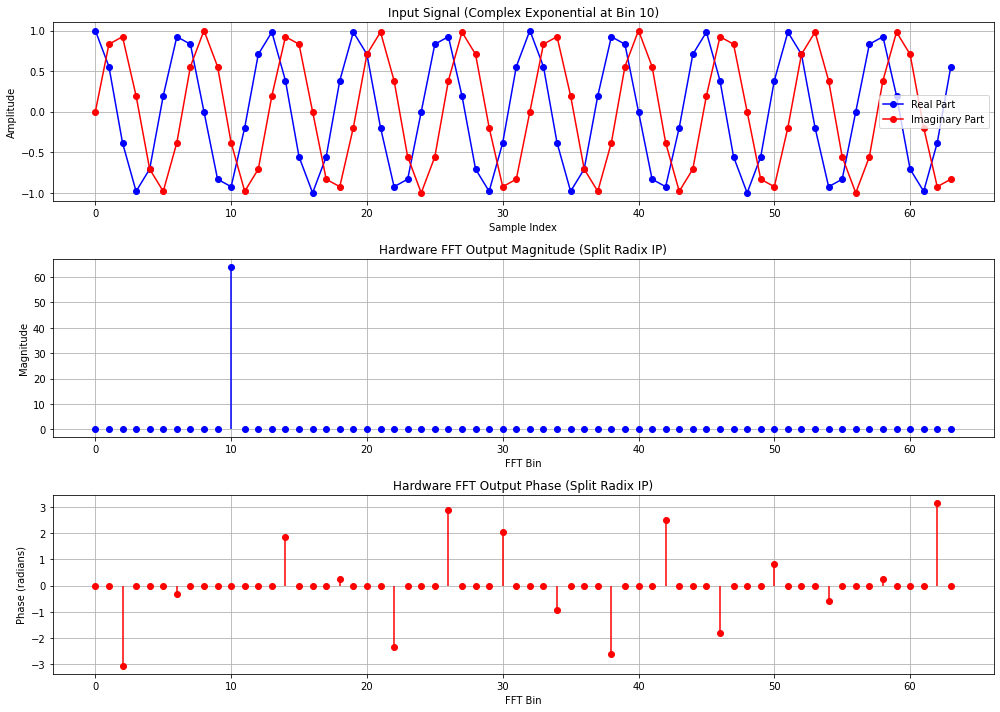

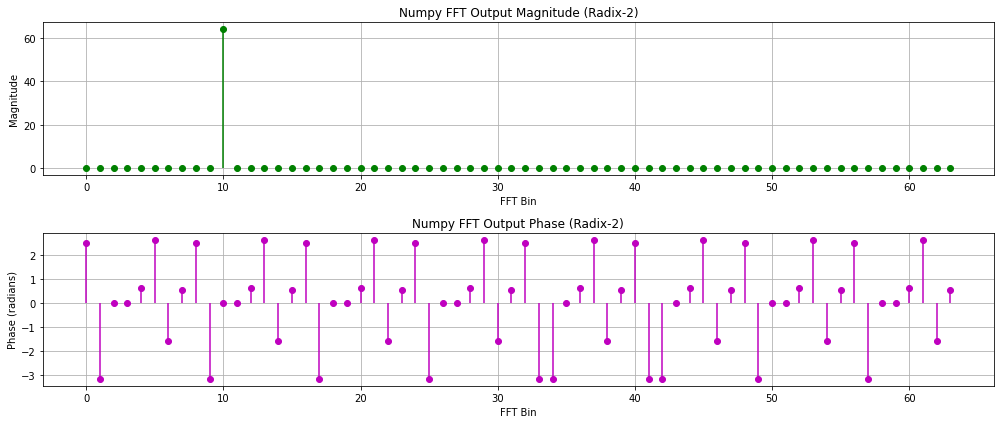

In [39]:
import numpy as np
import time
from pynq import MMIO
import matplotlib.pyplot as plt

CTRL_BASEADDR = 0x40000000
CTRL_SPACE = 0x1000
N = 64
NUM_BANKS = 8
SAMPLES_PER_BANK = 8
FIXED_POINT_FRACTIONAL = 16

INPUT_OFFSETS = [0x040 + 0x40 * i for i in range(NUM_BANKS)]
OUTPUT_OFFSETS = [0x240 + 0x40 * i for i in range(NUM_BANKS)]
AP_CTRL_OFFSET = 0x000

mmio = MMIO(CTRL_BASEADDR, CTRL_SPACE)

def float_to_fixed(flt):
    scaled = int(np.round(flt * (1 << FIXED_POINT_FRACTIONAL)))
    if scaled >= (1 << 31):
        scaled -= (1 << 32)
    elif scaled < -(1 << 31):
        scaled += (1 << 32)
    return np.uint32(scaled & 0xFFFFFFFF)

def fixed_to_float(fx):
    fx &= 0xFFFFFFFF
    if fx & 0x80000000:
        fx_signed = fx - 0x100000000
    else:
        fx_signed = fx
    return fx_signed / float(1 << FIXED_POINT_FRACTIONAL)

def write_complex_bank(bank_num, complex_data):
    if len(complex_data) != SAMPLES_PER_BANK:
        raise ValueError(f"Bank {bank_num} must have exactly {SAMPLES_PER_BANK} samples")
    base = INPUT_OFFSETS[bank_num]
    for i, c in enumerate(complex_data):
        real_fixed = float_to_fixed(np.real(c))
        imag_fixed = float_to_fixed(np.imag(c))
        mmio.write(base + i * 8, int(real_fixed))
        mmio.write(base + i * 8 + 4, int(imag_fixed))

def read_complex_bank(bank_num):
    base = OUTPUT_OFFSETS[bank_num]
    complex_vals = []
    for i in range(SAMPLES_PER_BANK):
        real_fixed = mmio.read(base + i * 8)
        imag_fixed = mmio.read(base + i * 8 + 4)
        real_float = fixed_to_float(real_fixed)
        imag_float = fixed_to_float(imag_fixed)
        complex_vals.append(real_float + 1j * imag_float)
    return np.array(complex_vals, dtype=np.complex64)

def write_all_input_banks(input_data):
    if len(input_data) != N:
        raise ValueError(f"Input data length must be {N}")
    for b in range(NUM_BANKS):
        bank_data = input_data[b*SAMPLES_PER_BANK:(b+1)*SAMPLES_PER_BANK]
        write_complex_bank(b, bank_data)

def read_all_output_banks():
    output_data = []
    for b in range(NUM_BANKS):
        bank_data = read_complex_bank(b)
        output_data.extend(bank_data)
    return np.array(output_data)

def start_fft():
    ctrl_val = mmio.read(AP_CTRL_OFFSET)
    mmio.write(AP_CTRL_OFFSET, ctrl_val | 0x1)

def is_fft_done():
    ctrl_val = mmio.read(AP_CTRL_OFFSET)
    return ((ctrl_val >> 1) & 0x1) == 1

def wait_for_fft_done(timeout=2.0):
    start_time = time.time()
    while not is_fft_done():
        if time.time() - start_time > timeout:
            raise TimeoutError("FFT did not complete in time")
        time.sleep(0.001)

def reset_ip():
    mmio.write(AP_CTRL_OFFSET, 0)

def generate_input_signal(freq_bin=10):
    input_signal = np.zeros(N, dtype=np.complex64)
    for i in range(N):
        phase = 2 * np.pi * freq_bin * i / N
        input_signal[i] = np.cos(phase) + 1j * np.sin(phase)
    return input_signal

def run_fft_test_and_plot(freq_bin=10):
    print("Resetting IP...")
    reset_ip()
    time.sleep(0.01)

    print("Generating input signal...")
    input_signal = generate_input_signal(freq_bin)

    print("Writing input data to IP...")
    write_all_input_banks(input_signal)

    print("Starting FFT...")
    start_fft()

    print("Waiting for FFT to complete...")
    wait_for_fft_done()

    print("Reading FFT output...")
    hw_fft_output = read_all_output_banks()

    print("Calculating numpy FFT...")
    np_fft_output = np.fft.fft(input_signal)

    # Plot input signal real and imaginary parts
    plt.figure(figsize=(14, 10))
    plt.subplot(3, 1, 1)
    plt.plot(np.real(input_signal), 'b-o', label='Real Part')
    plt.plot(np.imag(input_signal), 'r-o', label='Imaginary Part')
    plt.title('Input Signal (Complex Exponential at Bin %d)' % freq_bin)
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.legend()

    # Plot hardware FFT output magnitude and phase
    plt.subplot(3, 1, 2)
    plt.stem(np.abs(hw_fft_output), linefmt='b-', markerfmt='bo', basefmt=' ')
    plt.title('Hardware FFT Output Magnitude (Split Radix IP)')
    plt.xlabel('FFT Bin')
    plt.ylabel('Magnitude')
    plt.grid(True)

    plt.subplot(3, 1, 3)
    plt.stem(np.angle(hw_fft_output), linefmt='r-', markerfmt='ro', basefmt=' ')
    plt.title('Hardware FFT Output Phase (Split Radix IP)')
    plt.xlabel('FFT Bin')
    plt.ylabel('Phase (radians)')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Additional plot for numpy FFT output magnitude and phase for comparison
    plt.figure(figsize=(14, 6))
    plt.subplot(2, 1, 1)
    plt.stem(np.abs(np_fft_output), linefmt='g-', markerfmt='go', basefmt=' ')
    plt.title('Numpy FFT Output Magnitude (Radix-2)')
    plt.xlabel('FFT Bin')
    plt.ylabel('Magnitude')
    plt.grid(True)

    plt.subplot(2, 1, 2)
    plt.stem(np.angle(np_fft_output), linefmt='m-', markerfmt='mo', basefmt=' ')
    plt.title('Numpy FFT Output Phase (Radix-2)')
    plt.xlabel('FFT Bin')
    plt.ylabel('Phase (radians)')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Return results for further analysis if needed
    return hw_fft_output, np_fft_output

# Run and plot for frequency bin 10 for demonstration
hw_fft, np_fft = run_fft_test_and_plot(10)


Resetting IP...
Generating cosine input signal...
Writing input data to IP...
Starting FFT...
Waiting for FFT to complete...
Reading FFT output...
Calculating numpy FFT...


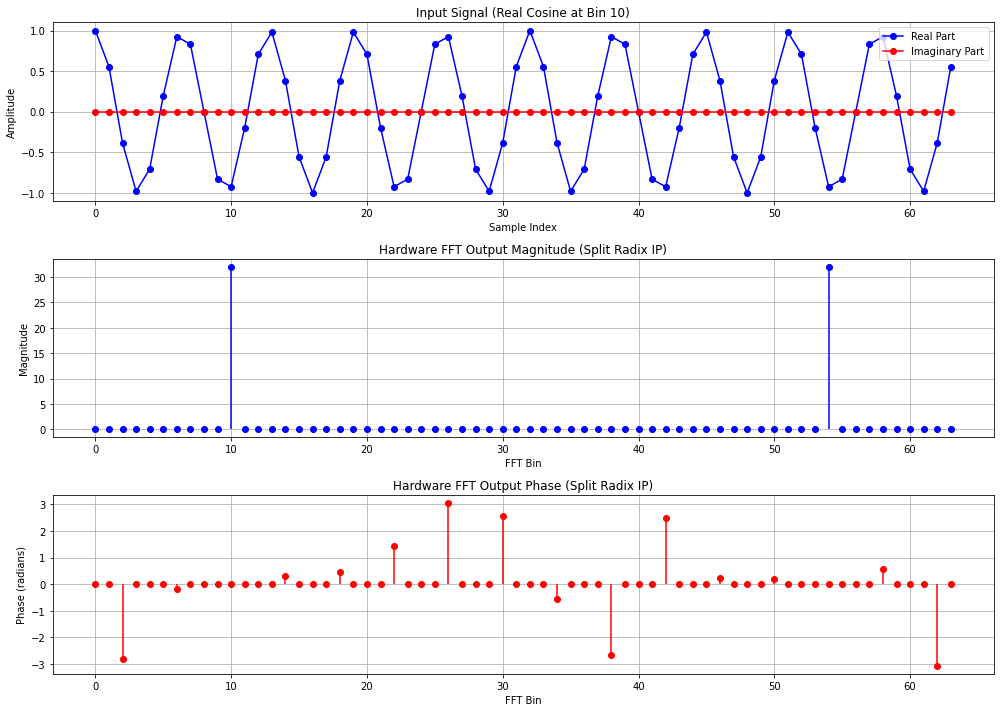

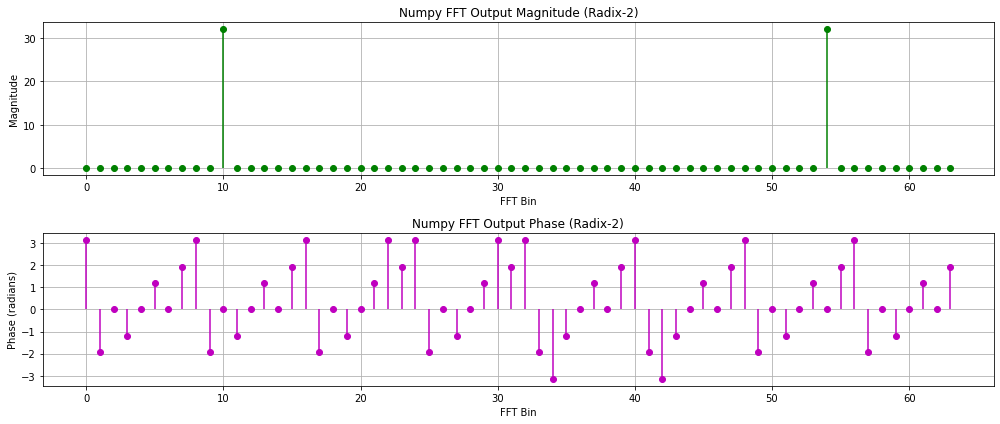

In [40]:
import numpy as np
import time
from pynq import MMIO
import matplotlib.pyplot as plt

CTRL_BASEADDR = 0x40000000
CTRL_SPACE = 0x1000
N = 64
NUM_BANKS = 8
SAMPLES_PER_BANK = 8
FIXED_POINT_FRACTIONAL = 16

INPUT_OFFSETS = [0x040 + 0x40 * i for i in range(NUM_BANKS)]
OUTPUT_OFFSETS = [0x240 + 0x40 * i for i in range(NUM_BANKS)]
AP_CTRL_OFFSET = 0x000

mmio = MMIO(CTRL_BASEADDR, CTRL_SPACE)

def float_to_fixed(flt):
    scaled = int(np.round(flt * (1 << FIXED_POINT_FRACTIONAL)))
    if scaled >= (1 << 31):
        scaled -= (1 << 32)
    elif scaled < -(1 << 31):
        scaled += (1 << 32)
    return np.uint32(scaled & 0xFFFFFFFF)

def fixed_to_float(fx):
    fx &= 0xFFFFFFFF
    if fx & 0x80000000:
        fx_signed = fx - 0x100000000
    else:
        fx_signed = fx
    return fx_signed / float(1 << FIXED_POINT_FRACTIONAL)

def write_complex_bank(bank_num, complex_data):
    if len(complex_data) != SAMPLES_PER_BANK:
        raise ValueError(f"Bank {bank_num} must have exactly {SAMPLES_PER_BANK} samples")
    base = INPUT_OFFSETS[bank_num]
    for i, c in enumerate(complex_data):
        real_fixed = float_to_fixed(np.real(c))
        imag_fixed = float_to_fixed(np.imag(c))
        mmio.write(base + i * 8, int(real_fixed))
        mmio.write(base + i * 8 + 4, int(imag_fixed))

def read_complex_bank(bank_num):
    base = OUTPUT_OFFSETS[bank_num]
    complex_vals = []
    for i in range(SAMPLES_PER_BANK):
        real_fixed = mmio.read(base + i * 8)
        imag_fixed = mmio.read(base + i * 8 + 4)
        real_float = fixed_to_float(real_fixed)
        imag_float = fixed_to_float(imag_fixed)
        complex_vals.append(real_float + 1j * imag_float)
    return np.array(complex_vals, dtype=np.complex64)

def write_all_input_banks(input_data):
    if len(input_data) != N:
        raise ValueError(f"Input data length must be {N}")
    for b in range(NUM_BANKS):
        bank_data = input_data[b*SAMPLES_PER_BANK:(b+1)*SAMPLES_PER_BANK]
        write_complex_bank(b, bank_data)

def read_all_output_banks():
    output_data = []
    for b in range(NUM_BANKS):
        bank_data = read_complex_bank(b)
        output_data.extend(bank_data)
    return np.array(output_data)

def start_fft():
    ctrl_val = mmio.read(AP_CTRL_OFFSET)
    mmio.write(AP_CTRL_OFFSET, ctrl_val | 0x1)

def is_fft_done():
    ctrl_val = mmio.read(AP_CTRL_OFFSET)
    return ((ctrl_val >> 1) & 0x1) == 1

def wait_for_fft_done(timeout=2.0):
    start_time = time.time()
    while not is_fft_done():
        if time.time() - start_time > timeout:
            raise TimeoutError("FFT did not complete in time")
        time.sleep(0.001)

def reset_ip():
    mmio.write(AP_CTRL_OFFSET, 0)

def generate_cosine_input(freq_bin=10):
    # Real cosine wave, imaginary part zeros
    input_signal = np.zeros(N, dtype=np.complex64)
    for i in range(N):
        phase = 2 * np.pi * freq_bin * i / N
        input_signal[i] = np.cos(phase) + 0j  # Imaginary part zero
    return input_signal

def run_cosine_test_and_plot(freq_bin=10):
    print("Resetting IP...")
    reset_ip()
    time.sleep(0.01)

    print("Generating cosine input signal...")
    input_signal = generate_cosine_input(freq_bin)

    print("Writing input data to IP...")
    write_all_input_banks(input_signal)

    print("Starting FFT...")
    start_fft()

    print("Waiting for FFT to complete...")
    wait_for_fft_done()

    print("Reading FFT output...")
    hw_fft_output = read_all_output_banks()

    print("Calculating numpy FFT...")
    np_fft_output = np.fft.fft(input_signal)

    # Plot input signal real and imaginary parts
    plt.figure(figsize=(14, 10))
    plt.subplot(3, 1, 1)
    plt.plot(np.real(input_signal), 'b-o', label='Real Part')
    plt.plot(np.imag(input_signal), 'r-o', label='Imaginary Part')
    plt.title('Input Signal (Real Cosine at Bin %d)' % freq_bin)
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.legend()

    # Plot hardware FFT output magnitude and phase
    plt.subplot(3, 1, 2)
    plt.stem(np.abs(hw_fft_output), linefmt='b-', markerfmt='bo', basefmt=' ')
    plt.title('Hardware FFT Output Magnitude (Split Radix IP)')
    plt.xlabel('FFT Bin')
    plt.ylabel('Magnitude')
    plt.grid(True)

    plt.subplot(3, 1, 3)
    plt.stem(np.angle(hw_fft_output), linefmt='r-', markerfmt='ro', basefmt=' ')
    plt.title('Hardware FFT Output Phase (Split Radix IP)')
    plt.xlabel('FFT Bin')
    plt.ylabel('Phase (radians)')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Additional plot for numpy FFT output magnitude and phase for comparison
    plt.figure(figsize=(14, 6))
    plt.subplot(2, 1, 1)
    plt.stem(np.abs(np_fft_output), linefmt='g-', markerfmt='go', basefmt=' ')
    plt.title('Numpy FFT Output Magnitude (Radix-2)')
    plt.xlabel('FFT Bin')
    plt.ylabel('Magnitude')
    plt.grid(True)

    plt.subplot(2, 1, 2)
    plt.stem(np.angle(np_fft_output), linefmt='m-', markerfmt='mo', basefmt=' ')
    plt.title('Numpy FFT Output Phase (Radix-2)')
    plt.xlabel('FFT Bin')
    plt.ylabel('Phase (radians)')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return hw_fft_output, np_fft_output

# Run cosine test for frequency bin 10 with plots and comparison
hw_fft_cos, np_fft_cos = run_cosine_test_and_plot(10)


Bin	HW		NumPy
0	2080.0000	2080.0000
1	652.1583	652.1605
2	326.4722	326.4735
3	218.0886	218.0869
4	164.0264	164.0266
5	131.7003	131.6980
6	110.2371	110.2366
7	94.9879	94.9865
8	83.6199	83.6200
9	74.8448	74.8442
10	67.8847	67.8834
11	62.2452	62.2444
12	57.5991	57.5985
13	53.7204	53.7184
14	50.4430	50.4419
15	47.6530	47.6503
16	45.2548	45.2548
17	43.1905	43.1877
18	41.3966	41.3966
19	39.8406	39.8403
20	38.4865	38.4861
21	37.3083	37.3078
22	36.2841	36.2844
23	35.3979	35.3986
24	34.6364	34.6366
25	33.9871	33.9867
26	33.4400	33.4399
27	32.9906	32.9886
28	32.6270	32.6269
29	32.3512	32.3501
30	32.1541	32.1548
31	32.0396	32.0386
32	32.0000	32.0000
33	32.0411	32.0386
34	32.1554	32.1548
35	32.3530	32.3501
36	32.6274	32.6269
37	32.9892	32.9886
38	33.4394	33.4399
39	33.9877	33.9867
40	34.6370	34.6366
41	35.4007	35.3986
42	36.2858	36.2844
43	37.3089	37.3078
44	38.4870	38.4861
45	39.8408	39.8403
46	41.3966	41.3966
47	43.1897	43.1877
48	45.2548	45.2548
49	47.6502	47.6503
50	50.4414	50.4419
51	53.7184	

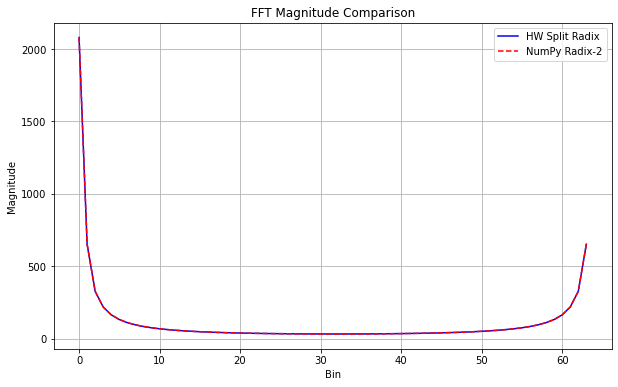

In [42]:
import numpy as np
import time
from pynq import MMIO
import matplotlib.pyplot as plt

CTRL_BASEADDR = 0x40000000
CTRL_SPACE = 0x1000
N = 64
NUM_BANKS = 8
SAMPLES_PER_BANK = 8
FIXED_POINT_FRACTIONAL = 16

INPUT_OFFSETS = [0x040 + 0x40 * i for i in range(NUM_BANKS)]
OUTPUT_OFFSETS = [0x240 + 0x40 * i for i in range(NUM_BANKS)]
AP_CTRL_OFFSET = 0x000

mmio = MMIO(CTRL_BASEADDR, CTRL_SPACE)

def float_to_fixed(flt):
    scaled = int(np.round(flt * (1 << FIXED_POINT_FRACTIONAL)))
    if scaled >= (1 << 31):
        scaled -= (1 << 32)
    elif scaled < -(1 << 31):
        scaled += (1 << 32)
    return np.uint32(scaled & 0xFFFFFFFF)

def float_to_fixed(flt):
    scaled = int(np.round(flt * (1 << FIXED_POINT_FRACTIONAL)))
    if scaled >= (1 << 31):
        scaled -= (1 << 32)
    elif scaled < -(1 << 31):
        scaled += (1 << 32)
    return np.uint32(scaled & 0xFFFFFFFF)

def write_complex_bank(bank_num, complex_data):
    base = INPUT_OFFSETS[bank_num]
    for i, c in enumerate(complex_data):
        mmio.write(base + i*8, int(float_to_fixed(c.real)))
        mmio.write(base + i*8+4, int(float_to_fixed(c.imag)))


def read_complex_bank(bank_num):
    base = OUTPUT_OFFSETS[bank_num]
    vals = []
    for i in range(SAMPLES_PER_BANK):
        r = fixed_to_float(mmio.read(base + i*8))
        im = fixed_to_float(mmio.read(base + i*8+4))
        vals.append(r + 1j*im)
    return np.array(vals)

def write_all(input_data):
    for b in range(NUM_BANKS):
        chunk = input_data[b*SAMPLES_PER_BANK:(b+1)*SAMPLES_PER_BANK]
        write_complex_bank(b, chunk)

def read_all():
    out = []
    for b in range(NUM_BANKS):
        out.extend(read_complex_bank(b))
    return np.array(out)

def start_fft():
    mmio.write(AP_CTRL_OFFSET, mmio.read(AP_CTRL_OFFSET)|1)

def fft_done():
    return bool((mmio.read(AP_CTRL_OFFSET)>>1)&1)

def wait_done(timeout=2.0):
    t0 = time.time()
    while not fft_done():
        if time.time()-t0>timeout:
            raise TimeoutError("FFT timed out")
        time.sleep(0.001)

def reset_ip():
    mmio.write(AP_CTRL_OFFSET,0)

def test_discrete(input_seq):
    if len(input_seq)!=N:
        raise ValueError("Input must be length 64")
    # to complex
    inp = np.array(input_seq, dtype=np.complex64)
    reset_ip(); time.sleep(0.01)
    write_all(inp)
    start_fft(); wait_done()
    hw_out = read_all()
    np_out = np.fft.fft(inp)
    # print magnitudes
    print("Bin\tHW\t\tNumPy")
    for i in range(N):
        print(f"{i}\t{abs(hw_out[i]):.4f}\t{abs(np_out[i]):.4f}")
    # plot comparison
    plt.figure(figsize=(10,6))
    plt.plot(abs(hw_out), 'b-', label='HW Split Radix')
    plt.plot(abs(np_out), 'r--', label='NumPy Radix-2')
    plt.title('FFT Magnitude Comparison')
    plt.xlabel('Bin')
    plt.ylabel('Magnitude')
    plt.legend()
    plt.grid(True)
    plt.show()
    return hw_out, np_out

# Example discrete sequence: 1,2,3,...,64
sequence = np.arange(1, N+1)
hw_fft, np_fft = test_discrete(sequence)
